# 🧠 Classification-Driven Retrieval System using LangGraph

In this notebook, we explore how to build a **Classification-Driven Retrieval System** using **LangGraph** – a graph-based framework for orchestrating language model agents.

---

## 🧐 What is a Classification-Driven Retrieval System?

A **Classification-Driven Retrieval System** is a system where the **user query is first classified** into one of several predefined categories, and **based on that classification**, a **specialized retriever** or **document set** is used to fetch relevant content.

### ✨ Key Idea:
> _"Route the question to the right documents using classification before retrieval."_  
This improves precision and makes responses more context-aware.

---

## 🧱 Components of the System

### **1. Input Node**
- Accepts a user query.

### **2. Classifier Node**
- Uses a language model to classify the query into a topic such as:
  - *Healthcare*, *Finance*, *Technology*, etc.

### **3. Router Node**
- Directs the query to the appropriate retriever based on classification.

### **4. Retriever Nodes**
- Each retriever searches a vector store built on documents of a particular domain.

### **5. Answer Generator Node**
- Summarizes or answers using retrieved content.

---


## 💡 Example Use Case

> A chatbot that answers user questions differently if it's about medical info vs. banking transactions vs. software errors.


In [61]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [62]:
from dotenv import load_dotenv
load_dotenv()

True

In [63]:
documents = [
    Document(
        page_content="""Anytime Fitness is a global chain of 24-hour health and fitness clubs that aims to make fitness accessible and convenient for everyone. With over 5,000 locations in more than 30 countries, it has become a popular choice for people with busy schedules. One of its standout features is the ability to access any gym location worldwide with just one membership. This flexibility is especially useful for frequent travelers or professionals who relocate often. Each facility typically includes cardio equipment, weight training machines, free weights, and sometimes personal training services or group classes. Security and member safety are top priorities, with 24/7 surveillance and secure key access. The consistent availability, combined with a community-oriented approach, helps members stay on track with their fitness goals regardless of location or time constraints.""",
    ),
    Document(
        page_content="""The environment at Anytime Fitness is designed to be welcoming and non-intimidating, attracting a wide range of members from beginners to seasoned athletes. Their slogan, “Let’s make healthy happen,” reflects their mission to support a healthier lifestyle for everyone, no matter their fitness level. Most gyms offer personalized fitness plans and access to professional trainers who guide members through customized workouts based on their goals. Many locations also include digital wellness tools, like mobile apps for workout tracking and virtual training. This tech-enabled approach appeals to modern fitness enthusiasts who want on-demand guidance and flexibility. The franchise model allows local owners to run their own gyms while still benefiting from the broader brand, ensuring community-focused service that maintains high standards. Overall, the friendly staff, clean facilities, and supportive resources create an encouraging environment where members feel motivated to improve their fitness routines.""",
    ),
    Document(
        page_content="""Beyond equipment and workouts, Anytime Fitness emphasizes holistic health and well-being. Some clubs offer amenities like wellness coaching, nutritional advice, and mental health resources. Their integrated approach to fitness makes it easier for individuals to adopt and maintain a healthy lifestyle. The brand often partners with local events, wellness challenges, and charity initiatives to engage members and give back to the community. These activities foster a sense of belonging and accountability among members. In addition, Anytime Fitness supports long-term transformation through its “AF Challenge,” a structured program focused on measurable progress. This makes it easier for members to set realistic goals and stay consistent. Their membership model is competitively priced and often includes features like guest passes, referral benefits, and discounts for long-term signups. All these elements make Anytime Fitness not just a place to work out, but a supportive hub for building better physical and mental health.""",
    ),
]

In [64]:
embedding_function = OpenAIEmbeddings()

In [65]:
database = Chroma.from_documents(embedding=embedding_function, documents=documents)

In [66]:
retriever = database.as_retriever(search_type ="mmr", search_kwargs = {"k":3})

In [67]:
retriever.invoke("what are the best features of anytime fitness")

[Document(metadata={}, page_content='Anytime Fitness is a global chain of 24-hour health and fitness clubs that aims to make fitness accessible and convenient for everyone. With over 5,000 locations in more than 30 countries, it has become a popular choice for people with busy schedules. One of its standout features is the ability to access any gym location worldwide with just one membership. This flexibility is especially useful for frequent travelers or professionals who relocate often. Each facility typically includes cardio equipment, weight training machines, free weights, and sometimes personal training services or group classes. Security and member safety are top priorities, with 24/7 surveillance and secure key access. The consistent availability, combined with a community-oriented approach, helps members stay on track with their fitness goals regardless of location or time constraints.'),
 Document(metadata={}, page_content='The environment at Anytime Fitness is designed to be

In [68]:
from langchain_core.prompts import ChatPromptTemplate

template = '''
Answer the question based on the following context : {context}
Question : {question}
'''

prompt = ChatPromptTemplate.from_template(template=template)


In [69]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [70]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

rag_chain = prompt | llm    

In [71]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import END, add_messages, StateGraph
from langchain.schema import Document

In [72]:
class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents : list[Document]
    on_topic : str

In [73]:
from pydantic import BaseModel , Field

class GradeQuestion(BaseModel):
    """
    "Boolean value to check wether the question is from Anytime fitness gym or not
    """
    score : str = Field(description = "Question is about gym? if yes --> 'yes' else not --? 'no'")

In [74]:
def question_classifier(state:AgentState):
    question = state["messages"][-1].content
    system = """ You are classifier that determines wether a user input is about one of the following topics
    1. Gym history or founder
    2. Operating hours
    3. membership plans
    4. fitness classes
    5. Personal trainer
    6. Facilieties and equipment

    if the question is about any of these topics respond with 'yes'. Otherwise respond 'no'.

    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [("system",system) , ("human", "user question: {question}")
         
         
         ]
    )

    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm

    result = grader_llm.invoke({'question':question})

    state["on_topic"] = result.score
    return state

In [75]:
def on_topic_router(state : AgentState):
    on_topic = state["on_topic"] 
    if on_topic.lower()=="yes":
        return "on_topic"
    else:
        return "off_topic"

In [76]:
def retrieve(state : AgentState):
    question = state["messages"][-1].content

    documents = retriever.invoke(question)
    state["documents"] = documents
    return state

In [77]:
def generate_answer(state: AgentState):
    question =state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context":documents,"question": question})

    state['messages'].append(generation)
    

In [78]:
def off_topic_response(state: AgentState):
    state["messages"].append(AIMessage(content="I am sorry!I cannot answer these questions"))
    return state

In [79]:
graph = StateGraph(AgentState)

graph.add_node("Question_classifier", question_classifier)
graph.add_node("retriever", retrieve)
graph.add_node("generate_answer", generate_answer)
graph.add_node("off_topic_response", off_topic_response)

graph.add_conditional_edges("Question_classifier", on_topic_router,{"on_topic":"retriever", "off_topic":"off_topic_response"})

graph.add_edge("retriever", "generate_answer")
graph.add_edge("generate_answer", END)
graph.add_edge("off_topic_response", END)

graph.set_entry_point("Question_classifier")

In [80]:
app = graph.compile()

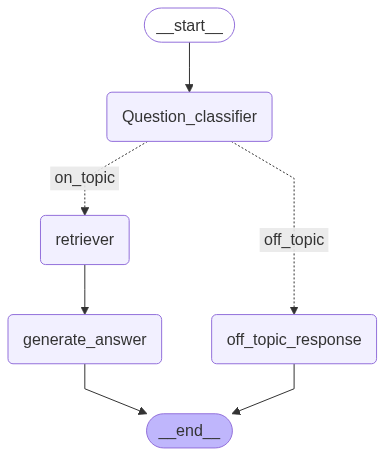

In [81]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image (app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
           
           )
)

In [82]:
app.invoke(input={"messages": [HumanMessage(content="Facilieties and equipment at anytime fitness")]})

c:\Users\kanha\anaconda3\Lib\site-packages\langchain_openai\chat_models\base.py:1413: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'messages': [HumanMessage(content='Facilieties and equipment at anytime fitness', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Facilities and equipment at Anytime Fitness typically include cardio equipment, weight training machines, free weights, and sometimes personal training services or group classes. Additionally, they offer amenities like wellness coaching, nutritional advice, and mental health resources to promote holistic health and well-being. Some locations also include digital wellness tools, such as mobile apps for workout tracking and virtual training, to cater to modern fitness enthusiasts who seek on-demand guidance and flexibility.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 549, 'total_tokens': 635, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 

In [83]:
app.invoke(input={"messages": [HumanMessage(content="gyms near anytime fitness gym")]})

c:\Users\kanha\anaconda3\Lib\site-packages\langchain_openai\chat_models\base.py:1413: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'messages': [HumanMessage(content='gyms near anytime fitness gym', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I am sorry!I cannot answer these questions', additional_kwargs={}, response_metadata={})],
 'on_topic': 'no'}